In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !pip install -r requirements.txt
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import resize_images
from tensorflow import convert_to_tensor
from tensorflow.keras.layers import Input

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim import lr_scheduler
# import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader


%matplotlib inline
import time
import os
import copy
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

# matrices
import datetime
import pytz
from google.colab import output

# deskewing
# %cd /content/drive/My\ Drive/Colab\ Notebooks
# from preprocessing import deskew

2.2.0-rc3


In [0]:
# load data as torch tensors
train_imgs = pickle.load(open("train_images_512.pk",'rb'), encoding='uint8')
train_labels = pickle.load(open("train_labels_512.pk",'rb'), encoding='latin1')
test_imgs = pickle.load(open("test_images_512.pk",'rb'), encoding='latin1')

/content/drive/.shortcut-targets-by-id/1o4Bv8NeHccMipIjsCq3qSnmW3y1iSSI9/340 final COVID


0.99999994
0.0


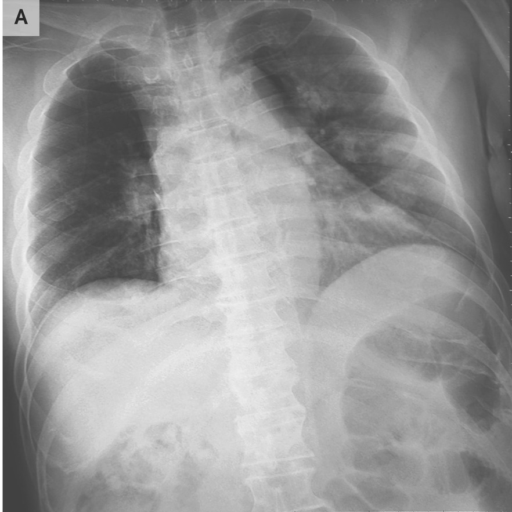

In [0]:
################################
# PREPROCESSING
################################
# 1. rescale images (de-normalize)
train_imgs_rescaled = (train_imgs+1)*127.5 # assuming min-max normalization
# train_imgs_rescaled = -train_imgs*255 # alternative scheme
X_train = train_imgs_rescaled.numpy()

# min/max stats
print(X_train.max())
print(X_train.min())

# preview the image
test_image = torchvision.transforms.ToPILImage()(train_imgs_rescaled[0])
test_image

In [0]:
# 2. change data format to channel last
tf.keras.backend.set_image_data_format('channels_last')
X_train = train_imgs.numpy()
X_train = np.moveaxis(X_train, 1, -1)
y_train = train_labels.numpy()

# check how many samples are in each class
print(np.unique(y_train, return_counts=True))

# shape stats
print(X_train.shape)
print(y_train.shape)

(array([0, 1]), array([15, 55]))
(70, 512, 512, 3)
(70,)


In [0]:
# 3. data augmentation:
# main augmentation scheme: double number of examples, preserve class ratio
datagen = ImageDataGenerator(rotation_range=30,                 
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            fill_mode='nearest')
batch_size = len(X_train)
aug_iter = datagen.flow(X_train, y_train, batch_size=batch_size)
batch = aug_iter.next()
X_train = np.vstack((X_train, batch[0])) # add augmentation to original setd
y_train = np.hstack((y_train, batch[1]))


## Alternative augmentation scheme: balance number of examples for each class
# ones_ind = np.where(y_train==1)  # num ones
# zeros_ind = np.where(y_train==0) # num zeros

# aug_iter = datagen.flow(X_train[ones_ind], y_train[ones_ind], batch_size=len(ones_ind[0])) # augment with ones
# for i in range(2): # 55+55*2=165
#   one_batch = aug_iter.next()
#   X_train = np.vstack((X_train, one_batch[0]))
#   y_train = np.hstack((y_train, one_batch[1]))


# aug_iter = datagen.flow(X_train[zeros_ind], y_train[zeros_ind], batch_size=len(zeros_ind[0])) # augment with zeros
# for i in range(10): # 15+15*10=165
#   zero_batch = aug_iter.next()
#   X_train = np.vstack((X_train, zero_batch[0]))
#   y_train = np.hstack((y_train, zero_batch[1]))

In [0]:
# 4.1 preprocess for ResNet
X_train_res = resnet_preprocess_input(X_train)
print(X_train_res.max())
print(X_train_res.min())

-104.93116
-124.68


In [0]:
# 4.2 preprocess for Inception
X_train_inc = inception_preprocess_input(X_train)
print(X_train_inc.max())
print(X_train_inc.min())

-1.8229895
-1.9778824


In [0]:
# 4.3 preprocess for VGG16
X_train_vgg = vgg_preprocess_input(X_train)
print(X_train_vgg.max())
print(X_train_vgg.min())

-105.76199
-125.65788


In [0]:
################################
# DATASET PREPROCESSING
################################

# 1. split into train and validation sets
skf = StratifiedKFold(n_splits=5)
train_indices = None
test_indices = None
for train_index, test_index in skf.split(X_train, y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_indices = train_index
    test_indices = test_index
    break

# 1.1 for ResNet
X_train_res = X_train_res[train_indices]
X_val_res = X_train_res[test_indices]
y_train_res = y_train[train_indices]
y_val_res = y_train[test_indices]

# 1.2 for InceptionV3
X_train_inc = X_train_inc[train_indices]
X_val_inc = X_train_inc[test_indices]
y_train_inc = y_train[train_indices]
y_val_inc = y_train[test_indices]

# 1.3 for VGG
X_train_vgg = X_train_vgg[train_indices]
X_val_vgg = X_train_vgg[test_indices]
y_train_vgg = y_train[train_indices]
y_val_vgg = y_train[test_indices]

TRAIN: [ 12  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]


In [0]:
# 2. try using dummy classifier to get a baseline score
dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train, y_train)
dc.score(X_train, y_train)

0.7857142857142857

In [0]:
# 3. convert y's to multiclass
Y_train_res = tf.keras.utils.to_categorical(y_train_res, num_classes=2, dtype='float32')
Y_val_res = tf.keras.utils.to_categorical(y_val_res, num_classes=2, dtype='float32')
Y_train_inc = tf.keras.utils.to_categorical(y_train_inc, num_classes=2, dtype='float32')
Y_val_inc = tf.keras.utils.to_categorical(y_val_inc, num_classes=2, dtype='float32')
Y_train_vgg = tf.keras.utils.to_categorical(y_train_vgg, num_classes=2, dtype='float32')
Y_val_vgg = tf.keras.utils.to_categorical(y_val_vgg, num_classes=2, dtype='float32')

In [0]:
################################
# MODEL ARCHITECTURE
################################

#########################
# 1. ResNet50
#########################

# create the base pre-trained model
input_tensor = Input(shape=(512, 512, 3))
base_model = ResNet50(input_tensor=input_tensor,weights='imagenet', include_top=False)

# add the top layers
x = base_model.output
x = GlobalAveragePooling2D()(x) # add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x) # add a fully-connected layer
x = Dropout(0.5)(x)  # add a dropout layer
predictions = Dense(2, activation='softmax')(x) # add a final prediction layer

# final model
resnet_model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

# optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

# compile
resnet_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
#########################
# 2. InceptionV3
#########################

# create the base pre-trained model
input_tensor = Input(shape=(512, 512, 3))
base_model_inc = InceptionV3(input_tensor=input_tensor,weights='imagenet', include_top=False)

# add the top layers
x = base_model_inc.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
inception_model = Model(inputs=base_model_inc.input, outputs=predictions)

# final model
for layer in base_model_inc.layers:
    layer.trainable = False

# optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)
# compile
inception_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
#########################
# 3. VGG16
#########################

input_tensor = Input(shape=(512, 512, 3))
base_model_VGG = VGG16(input_tensor = input_tensor, weights='imagenet', include_top=False)

# add the final layers
x = base_model_inc.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
vgg_model = Model(inputs=base_model_inc.input, outputs=predictions)

# final model
for layer in base_model_inc.layers:
    layer.trainable = False

# optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)
# compile
vgg_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
################################
# Training
################################

######################################
# 1. Run Stratified K-fold on ResNet50
######################################
resnet_result = []
batch_size=4
epochs=30
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_train_res, y_train_res):
    print("TRAIN:", train_index, "TEST:", test_index)
    print('0/1 ratio: ', np.sum(y_train_res[test_index]==0)/np.sum(y_train_res[test_index]==1))
    
    X_tr, X_valid = X_train_res[train_index], X_train_res[test_index]
    y_tr, y_valid = Y_train_res[train_index], Y_train_res[test_index]
    X_tr = convert_to_tensor(X_tr)
    X_valid = convert_to_tensor(X_valid)
    resnet_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    resnet_res = resnet_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                   validation_data=(X_valid, y_valid),
                   shuffle=False,
                   class_weight={0:2.7, 1:1})  # using class_weight to help with class imbalance 
    resnet_result.append(resnet_res)

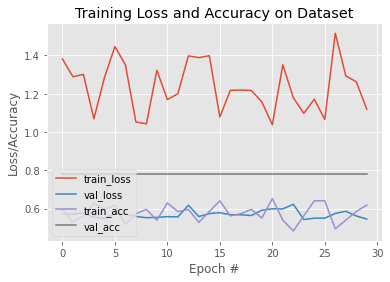

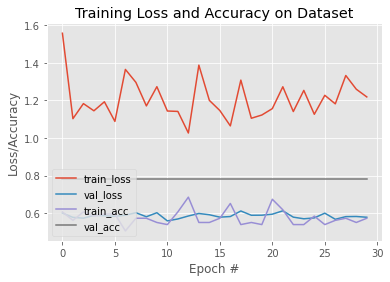

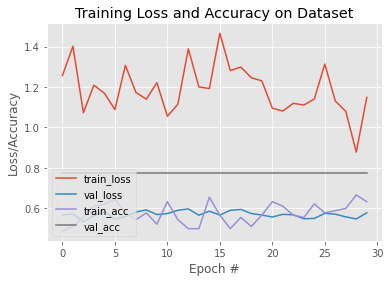

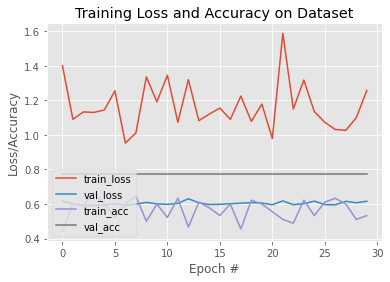

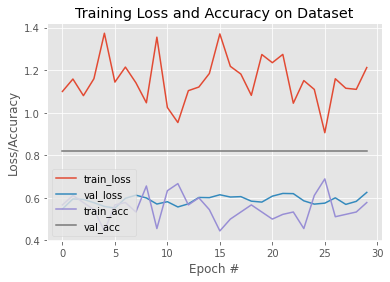

In [0]:
######################################
# 1.1 Plotting the results for ResNet
######################################
for res in resnet_result:
  N = epochs
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), res.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), res.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, N), res.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, N), res.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")

In [0]:
#########################################
# 2. Run Stratified K-fold on InceptionV3
#########################################
inception_result = []
batch_size=8
epochs=20
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_train_inc, y_train_inc):
    print("TRAIN:", train_index, "TEST:", test_index)
    print('0/1 ratio: ', np.sum(y_train_inc[test_index]==0)/np.sum(y_train_inc[test_index]==1))
    
    X_tr, X_valid = X_train_inc[train_index], X_train_inc[test_index]
    y_tr, y_valid = Y_train_inc[train_index], Y_train_inc[test_index]
    X_tr = convert_to_tensor(X_tr)
    X_valid = convert_to_tensor(X_valid)
    inception_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    inception_res = inception_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                   validation_data=(X_valid, y_valid),
                   shuffle=False,
                   class_weight={0:2.7, 1:1})
    inception_result.append(inception_res)

TRAIN: [  6   7   8   9  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111] TEST: [ 0  1  2  3  4  5 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
0/1 ratio:  0.2777777777777778
Epoch 1/20
12/12 [==============================] - 2s 201ms/step - loss: 90.6726 - accuracy: 0.5843 - val_loss: 26.0658 - val_accuracy: 0.2174
Epoch 2/20
12/12 [==============================] - 1s 77ms/step - loss: 92.4838 - accuracy: 0.5393 - val_loss: 36.6279 - val_accuracy: 0.2174
Epoch 3/20
12/12 [==============================] - 1s 77ms/step - loss: 88.5027 - accuracy: 0.5281 - val_loss: 74.5026 - val_accuracy: 0.2174
Epoch 4/20
12/12 [==============================] - 1s 77ms/step - loss: 143.6768 - accuracy:

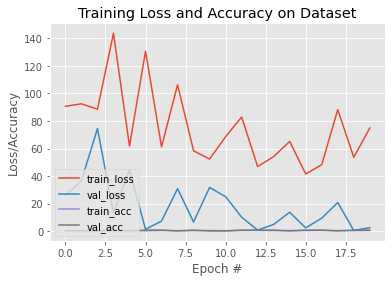

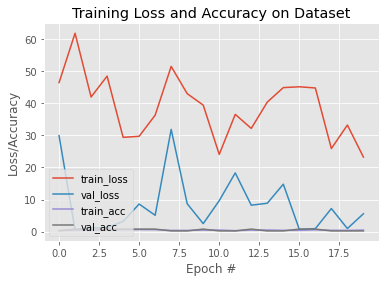

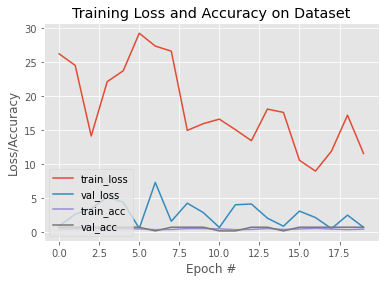

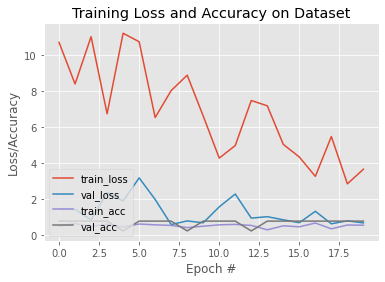

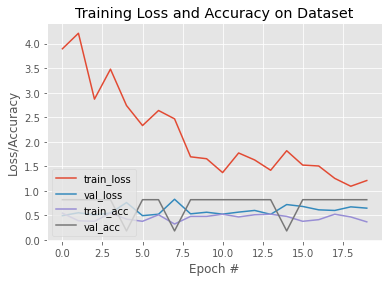

In [0]:
######################################
# 2.1 Plotting the results for InceptionV3
######################################
for res in inception_result:
  N = epochs
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), res.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), res.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, N), res.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, N), res.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")

In [0]:
#########################################
# 3. Run Stratified K-fold on VGG16
#########################################
vgg_result = []
batch_size=4
epochs=20
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_train_vgg, y_train_vgg):
    print("TRAIN:", train_index, "TEST:", test_index)
    print('0/1 ratio: ', np.sum(y_train_vgg[test_index]==0)/np.sum(y_train_vgg[test_index]==1))
    
    X_tr, X_valid = X_train_vgg[train_index], X_train_vgg[test_index]
    y_tr, y_valid = Y_train_vgg[train_index], Y_train_vgg[test_index]
    X_tr = convert_to_tensor(X_tr)
    X_valid = convert_to_tensor(X_valid)
    vgg_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    vgg_res = vgg_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                   validation_data=(X_valid, y_valid),
                   shuffle=False,
                   class_weight={0:2.7, 1:1})
    vgg_result.append(vgg_res)

TRAIN: [  6   7   8   9  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111] TEST: [ 0  1  2  3  4  5 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
0/1 ratio:  0.2777777777777778
Epoch 1/20
23/23 [==============================] - 2s 96ms/step - loss: 25.5125 - accuracy: 0.5843 - val_loss: 6.6325 - val_accuracy: 0.7826
Epoch 2/20
23/23 [==============================] - 1s 50ms/step - loss: 24.8736 - accuracy: 0.5056 - val_loss: 4.9687 - val_accuracy: 0.7826
Epoch 3/20
23/23 [==============================] - 1s 50ms/step - loss: 17.9244 - accuracy: 0.5955 - val_loss: 2.1312 - val_accuracy: 0.2174
Epoch 4/20
23/23 [==============================] - 1s 50ms/step - loss: 28.7422 - accuracy: 0.44

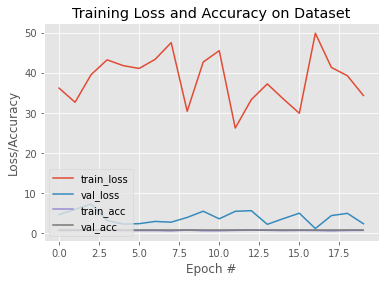

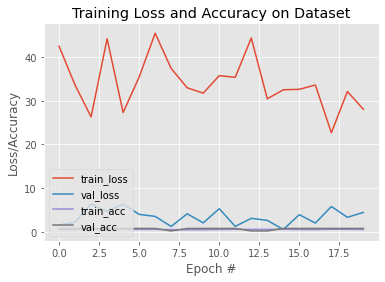

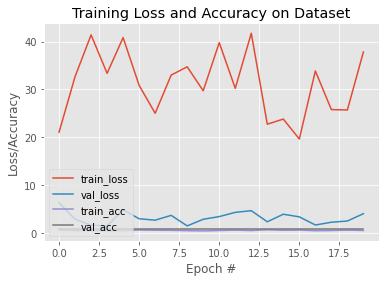

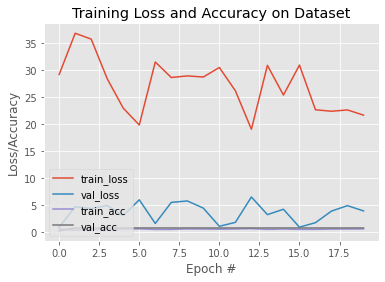

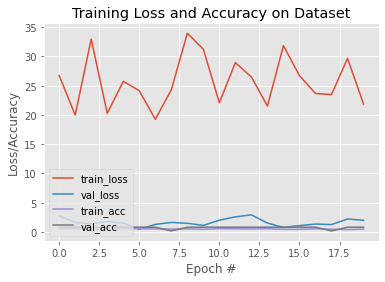

In [0]:
######################################
# 2.1 Plotting the results for VGG16
######################################
for res in vgg_result:
  N = epochs
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), res.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), res.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, N), res.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, N), res.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")

In [0]:
######################################
# Prediction for each model
######################################

##########
# 1. ResNet50
##########
train_score, train_acc = resnet_model.evaluate(X_train_res, Y_train_res, batch_size=1)
print('Train loss:', train_score)
print('Train accuracy:', train_acc)
val_score, val_acc = resnet_model.evaluate(X_val_res, Y_val_res, batch_size=1)
print('Validation loss:', val_score)
print('Validation accuracy:', val_acc)

In [0]:
## Classifcation report for ResNet Results
Y_pred = resnet_model.predict(X_val_res, batch_size=1)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_val_res.argmax(axis=1), y_pred))

In [0]:
# Confusion matrix, accuracy, sensitivity, and specificity for ResNet Results
matrix = confusion_matrix(Y_val_res.argmax(axis=1), y_pred)
total = sum(sum(matrix))
acc = (matrix[0, 0] + matrix[1, 1]) / total
sensitivity = matrix[0, 0] / (matrix[0, 0] + matrix[0, 1])
specificity = matrix[1, 1] / (matrix[1, 0] + matrix[1, 1])

print(matrix)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [0]:
##########
# 2.Inception
##########
train_score, train_acc = inception_model.evaluate(X_train_inc, Y_train_inc, batch_size=3)
print('Train loss:', train_score)
print('Train accuracy:', train_acc)
val_score, val_acc = inception_model.evaluate(X_val_inc, Y_val_inc, batch_size=3)
print('Validation loss:', val_score)
print('Validation accuracy:', val_acc)

In [0]:
# Classifcation report for Inception Results
Y_pred = inception_model.predict(X_val_inc, batch_size=1)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_val_inc.argmax(axis=1), y_pred))

In [0]:
# Confusion matrix, accuracy, sensitivity, and specificity for Inception Results
matrix = confusion_matrix(Y_val_inc.argmax(axis=1), y_pred)
total = sum(sum(matrix))
acc = (matrix[0, 0] + matrix[1, 1]) / total
sensitivity = matrix[0, 0] / (matrix[0, 0] + matrix[0, 1])
specificity = matrix[1, 1] / (matrix[1, 0] + matrix[1, 1])

print(matrix)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [0]:
# #########
# 3.VGG16
# #########
train_score, train_acc = vgg_model.evaluate(X_train_vgg, Y_train_vgg, batch_size=3)
print('Train loss:', train_score)
print('Train accuracy:', train_acc)
val_score, val_acc = vgg_model.evaluate(X_val_vgg, Y_val_vgg, batch_size=3)
print('Validation loss:', val_score)
print('Validation accuracy:', val_acc)

In [0]:
## Classifcation report for VGG16 Results
Y_pred = vgg_model.predict(X_val_vgg, batch_size=1)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_val_vgg.argmax(axis=1), y_pred))

In [0]:
# Confusion matrix, accuracy, sensitivity, and specificity for VGG16 Results
matrix = confusion_matrix(Y_val_vgg.argmax(axis=1), y_pred)
total = sum(sum(matrix))
acc = (matrix[0, 0] + matrix[1, 1]) / total
sensitivity = matrix[0, 0] / (matrix[0, 0] + matrix[0, 1])
specificity = matrix[1, 1] / (matrix[1, 0] + matrix[1, 1])

print(matrix)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [0]:
# ######################################
# # Prediction on test set
# ######################################

# preprocess test set
test_imgs_rescaled = (test_imgs+1)*127.5
X_test = test_imgs_rescaled.numpy()
X_test = np.moveaxis(X_test, 1, -1)
X_test_res = resnet_preprocess_input(X_test)
X_test_inc = inception_preprocess_input(X_test)
X_test_vgg = vgg_preprocess_input(X_test)

# predict with models
res_pred = np.argmax(resnet_model.predict(X_test_res, batch_size=1), axis=1)
inc_pred = np.argmax(resnet_model.predict(X_test_inc, batch_size=1), axis=1) 
vgg_pred = np.argmax(resnet_model.predict(X_test_vgg, batch_size=1), axis=1)

# ensemble with voting
from scipy.stats import mode
predicted = np.array([res_pred, inc_pred, vgg_pred])
predicted = np.squeeze(mode(predicted.T, axis=1)[0])

In [0]:
# ######################################
# # Failed or inconclusive experimets
# ######################################
# # 1. deskewing
# from scipy.ndimage import interpolation
# import scipy as sp
# import numpy as np

# # Acknowledgement: modified from https://fsix.github.io/mnist/Deskewing.html
# def _moments(image):
#     c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid

#     totalImage = np.sum(image) #sum of pixels
#     m0 = np.sum(c0*image)/totalImage #mu_x
#     m1 = np.sum(c1*image)/totalImage #mu_y
#     m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
#     m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
#     m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
#     mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
#     covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
#     return mu_vector, covariance_matrix

# def _deskew(image):
#     c,v = _moments(image)
#     alpha = v[0,1]/v[0,0]
#     affine = np.array([[1,0],[alpha,1]])
#     ocenter = np.array(image.shape)/2.0
#     offset = c-np.dot(affine,ocenter)
#     img = interpolation.affine_transform(image,affine,offset=offset)
#     return img

# def deskew(X, reshape=False):
#     """Computes the Euclidean distance between rows of 'X' and rows of 'Xtest'
#     TODO

#     Parameters
#     ----------
#     X : an N by D numpy array, representing N flatten images each with D pixels
#     Returns:


#     """
#     currents = []
#     for i in range(len(X)):
#       if (reshape):
#         currents.append(_deskew(X[i].reshape(28, 28)).flatten())
#       else:
#         currents.append(_deskew(X[i]))
#     return np.array(currents)
# train_imgs_deskewed_array = np.zeros_like(train_imgs_1.numpy())
# train_imgs_deskewed_array = np.zeros((70, 512, 512))
# a = np.sum(train_imgs_1.numpy(), axis=1)
# print(a.shape)
# print(train_imgs_1.shape)
# for i in range(3):
#   train_imgs_deskewed_array[:, i, :, :] = deskew(train_imgs_1.numpy()[:, i, :, :])

# train_imgs_deskewed_tensor = torch.from_numpy(train_imgs_deskewed_array)